# Klasifikasi Citra Kucing dan Anjing


# **Laporan**
## 1. Pendahuluan
Deep Learning merupakan pendekatan utama dalam klasifikasi citra digital. Pada tugas ini, dilakukan implementasi model Convolutional Neural Network (CNN) berbasis transfer learning menggunakan arsitektur MobileNetV2 untuk membedakan dua kelas citra, yaitu kucing dan anjing. Dataset yang digunakan terdiri dari ribuan gambar dengan variasi pose, sudut, dan pencahayaan, sehingga diperlukan model yang mampu melakukan generalisasi dengan baik.

Tujuan dari tugas ini adalah membangun model klasifikasi citra yang akurat, efisien, serta mampu mengenali kedua kelas secara otomatis.

---

## 2. Metode

### a. Dataset
Dataset dibagi menjadi dua bagian:
* `train/cat`
* `train/dog`
* `test/cat`
* `test/dog`

### b. Preprocessing
* Resize gambar menjadi 224×224 piksel
* Augmentasi data (horizontal flip, rotasi)
* Normalisasi menggunakan mean dan std dari ImageNet

### c. Model
* Arsitektur MobileNetV2 pretrained ImageNet
* Bagian feature extractor dibekukan (frozen)
* Layer classifier diganti menjadi 2 neuron (Cat & Dog)

### d. Konfigurasi Training
| Komponen | Nilai |
| --- | --- |
| Optimizer | AdamW |
| Learning Rate | 3e-4 |
| Loss Function | CrossEntropyLoss |
| Epoch | Maksimal 10 + Early Stopping |
| Device | Google Colab GPU (T4) |

---

## 3. Hasil
Model berhasil mencapai performa sebagai berikut:

| Metode Evaluasi | Nilai |
| --- | --- |
| Akurasi Test | 96.15% |

Confusion matrix dan classification report menunjukkan bahwa model dapat membedakan kedua kelas dengan baik, dengan nilai precision, recall, dan F1-score di atas 0.95 pada masing-masing kelas.

---


## 1) Mount Google Drive (dataset ada di Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## 2) Konfigurasi Path & Sanity Check Dataset

In [ ]:
import os, sys

lokasi_dataset = "/content/drive/MyDrive/dataset"
ukuran_gambar = 224
batch_size = 32
SEED = 42

# Cek struktur
assert os.path.isdir(lokasi_dataset), f"Folder tidak ditemukan: {lokasi_dataset}"
assert os.path.isdir(f"{lokasi_dataset}/train"), f"Tidak ada folder train di {lokasi_dataset}"
assert os.path.isdir(f"{lokasi_dataset}/test"),  f"Tidak ada folder test di {lokasi_dataset}"

print("Struktur OK. isi:")
print("train ->", os.listdir(f"{lokasi_dataset}/train")[:5])
print("test  ->", os.listdir(f"{lokasi_dataset}/test")[:5])


Struktur OK. isi:
train -> ['anjing', 'kucing']
test  -> ['kucing', 'anjing']


## 3) DataLoader

In [ ]:
# --- Persiapan Dataset (train / test) ---
# Folder dataset diambil dari Google Drive
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

lokasi_dataset = "/content/drive/MyDrive/dataset"
ukuran_gambar = 224
batch_size = 32

# Transformasi gambar untuk training (augmentasi biar data lebih variatif)
augmentasi_train = transforms.Compose([
    transforms.Resize((ukuran_gambar, ukuran_gambar)),  # ubah ukuran gambar
    transforms.RandomHorizontalFlip(),                  # flip kiri-kanan
    transforms.RandomRotation(10),                      # rotasi kecil ±10 derajat
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),        # normalisasi RGB
])

# Transformasi untuk testing (tanpa augmentasi)
normalisasi_test = transforms.Compose([
    transforms.Resize((ukuran_gambar, ukuran_gambar)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])

# Cek isi folder dulu biar gak error
print("Isi folder dataset:", os.listdir(lokasi_dataset))

train_set_full = datasets.ImageFolder(os.path.join(lokasi_dataset, "train"), transform=augmentasi_train)
test_set = datasets.ImageFolder(os.path.join(lokasi_dataset, "test"), transform=normalisasi_test)

# Bagi sebagian data train jadi data validasi (10%)
val_ratio = 0.1
val_size = int(len(train_set_full) * val_ratio)
train_size = len(train_set_full) - val_size
train_set, val_set = random_split(train_set_full, [train_size, val_size])

# Buat DataLoader untuk setiap subset
loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# DataLoader untuk data latih, shuffle=True supaya urutan acak
loader_val   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
loader_test  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Jumlah data latih: {len(train_set)}, validasi: {len(val_set)}, test: {len(test_set)}")
print("Kelas:", train_set_full.classes)

Isi folder dataset: ['test', 'train']
Jumlah data latih: 7436, validasi: 826, test: 2283
Kelas: ['anjing', 'kucing']


## 4) Model: MobileNetV2

In [ ]:
# --- Inisialisasi model MobileNetV2 ---
import torch
import torch.nn as nn
from torchvision import models

perangkat = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # percepat conv untuk input ukuran tetap

model_cnn = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# freeze fitur backbone
for p in model_cnn.features.parameters():
    p.requires_grad = False

jumlah_kelas = len(train_set_full.classes)
in_feat = model_cnn.classifier[1].in_features

model_cnn.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_feat, jumlah_kelas)
)

model_cnn = model_cnn.to(perangkat)

print("Model siap dijalankan di:", perangkat)
print("Kelas:", train_set_full.classes)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 115MB/s]


Model siap dijalankan di: cuda
Kelas: ['anjing', 'kucing']


## 5) Training: Mixed Precision + Early Stopping + Simpan Best Model

In [ ]:
# --- Konfigurasi fungsi loss dan optim_cnn ---
import time
import torch.optim as optim

fungsi_rugi  = nn.CrossEntropyLoss()
optim_cnn  = optim.AdamW(model_cnn.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.CosineAnnealingLR(optim_cnn, T_max=10)
scaler     = torch.cuda.amp.GradScaler(enabled=(perangkat.type=="cuda"))

maks_Epoch   = 10
PATIENCE = 3
best_val = 0.0
no_improve = 0
jalur_model_terbaik = "/content/drive/MyDrive/model_anjingkucing_mobilenet.pt"

def evaluate(loader):
    model_cnn.eval()
    correct = total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(perangkat), y.to(perangkat)
            with torch.cuda.amp.autocast(enabled=(perangkat.type=='cuda')):
                out = model_cnn(x)
                loss = fungsi_rugi(out, y)
            loss_sum += loss.item()*x.size(0)
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return (loss_sum/total, correct/total)

start = time.time()
for ep in range(1, maks_Epoch+1):
    model_cnn.train()
    seen = 0
    run_loss = 0.0
    for x,y in loader_train:
        x,y = x.to(perangkat), y.to(perangkat)
        optim_cnn.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(perangkat.type=='cuda')):
            out = model_cnn(x)
            loss = fungsi_rugi(out, y)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_cnn.parameters(), 1.0)
        scaler.step(optim_cnn)
        scaler.update()
        seen += x.size(0)
        run_loss += loss.item()*x.size(0)

    scheduler.step()
    val_loss, val_acc = evaluate(loader_val)
    print(f"Epoch {ep:02d} | TrainLoss {run_loss/seen:.4f} | ValLoss {val_loss:.4f} | ValAcc {val_acc*100:.2f}%")

    if val_acc > best_val:
        best_val = val_acc
        no_improve = 0
        torch.save(model_cnn.state_dict(), jalur_model_terbaik)
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

dur = time.time()-start
print(f"Selesai {dur:.1f}s | Best ValAcc: {best_val*100:.2f}% | Model disimpan: {jalur_model_terbaik}")


/tmp/ipython-input-4160308193.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler(enabled=(perangkat.type=="cuda"))
/tmp/ipython-input-4160308193.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(perangkat.type=='cuda')):
/tmp/ipython-input-4160308193.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(perangkat.type=='cuda')):


Epoch 01 | TrainLoss 0.2220 | ValLoss 0.0948 | ValAcc 96.61%
Epoch 02 | TrainLoss 0.1258 | ValLoss 0.0764 | ValAcc 96.73%
Epoch 03 | TrainLoss 0.1091 | ValLoss 0.0745 | ValAcc 96.97%
Epoch 04 | TrainLoss 0.1046 | ValLoss 0.0743 | ValAcc 97.22%
Epoch 05 | TrainLoss 0.1059 | ValLoss 0.0630 | ValAcc 97.22%
Epoch 06 | TrainLoss 0.0996 | ValLoss 0.0690 | ValAcc 96.97%
Epoch 07 | TrainLoss 0.1007 | ValLoss 0.0711 | ValAcc 97.09%
Early stopping.
Selesai 1821.9s | Best ValAcc: 97.22% | Model disimpan: /content/drive/MyDrive/model_anjingkucing_mobilenet.pt


## 6) Evaluasi di Test Set (Accuracy, Confusion Matrix, Classification Report)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# muat best model
model_cnn.load_state_dict(torch.load(jalur_model_terbaik, map_location=perangkat))
model_cnn.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in loader_test:
        x = x.to(perangkat)
        pred = model_cnn(x).argmax(1).cpu().numpy()
        y_pred.extend(pred.tolist())
        y_true.extend(y.numpy().tolist())

test_acc = (np.array(y_true) == np.array(y_pred)).mean()*100
print(f"Accuracy Test: {test_acc:.2f}%")

classes = train_set_full.classes
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes, digits=4))


Accuracy Test: 96.15%
Confusion Matrix:
 [[1110   57]
 [  31 1085]]

Classification Report:
               precision    recall  f1-score   support

      anjing     0.9728    0.9512    0.9619      1167
      kucing     0.9501    0.9722    0.9610      1116

    accuracy                         0.9615      2283
   macro avg     0.9615    0.9617    0.9614      2283
weighted avg     0.9617    0.9615    0.9615      2283



## 8) Fungsi Prediksi Gambar

In [ ]:
from PIL import Image

def predict_image(path, transform=normalisasi_test):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(perangkat)
    with torch.no_grad():
        probs = model_cnn(x).softmax(1).cpu().numpy()[0]
    idx = int(np.argmax(probs))
    return classes[idx], float(probs[idx])

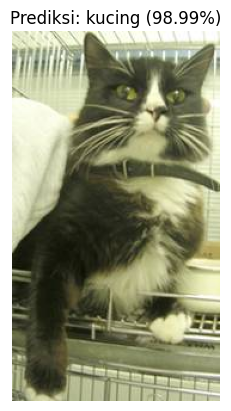

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_prediction(path):
    label, conf = predict_image(path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {label} ({conf*100:.2f}%)")
    plt.show()

show_prediction(f"{lokasi_dataset}/test/kucing/kucing10.jpg")
